## Zadanie domowe: Projektowanie filtru metodą okien

Zauważone w zadaniu z filtracją artefakty są efektem zastosowania filtru idealnego (wycięcia odpowiednich częstotliwości).
Aby je usunąć, należy filtr idealny w dziedzinie przestrzennej przemnożyć przez dwuwymiarowe okno (stworzone na podstawie jednowymiarowego).

1. Zdefiniuj rozmiar filtra (np. 21).

2. Stwórz okno np. Hamminga (`np.Hmming`) o zadanym rozmiarze.

3. Na podstawie tego okna stwórz okno dwuwymiarowe: $F = f^Tf$.
Można to zrealizować prostą instrukcją:
        hanning2d = np.outer(hanning, hanning)

4. Stwórz wzorcowy filtr idealny tak samo jak w poprzednim ćwiczeniu.
Jego rozmiar musi być taki sam jak zdefiniowany w punkcie pierwszym.

5. Generalna zasada jest taka, że należy obliczyć odwrotną transformatę Fouriera filtru idealnego.
Aby zagwarantować jednak dobrą lokalizację i symetryczność tworzonego filtru wykorzystuje się dodatkowe rotacje i przesunięcia.

        FilterFRot = np.rot90(np.fft.fftshift(np.rot90(FilterF, 2)), 2)
        FilterFRot3 = np.dstack((FilterFRot, np.zeros(FilterFRot.shape)))
        FilterFidft = cv2.idft(np.float32(FilterFRot3),
                        flags=cv2.DFT_SCALE | cv2.DFT_COMPLEX_OUTPUT)
        FilterFI = np.rot90(np.fft.fftshift(FilterFidft[:, :, 0]), 2)

6. Aby otrzymać poprawny filtr należy teraz pomnożyć dwuwymiarowe okno ze stworzonym filtrem idealnym w dziedzinie przestrzennej.

7. Stworzony filtr powinien zostać znowu przeniesiony do dziedziny częstotliwości.
Należy jednak rozszerzyć go tak, aby miał taki sam rozmiar jak filtrowany obraz.
Operację tę wykonaj tak samo jak w poprzednim ćwiczeniu (`cv2.copyMakeBorder`).
Oblicz transformatę Fouriera i wykonaj przesunięcie.
Następnie oblicz wartość bezwzględną (dzięki temu filtr nie będzie wpływał na fazę).
Wynikiem jest poprawiony filtr w dziedzinie częstotliwości.

8. Przeprowadź filtrację obrazu *lena.bmp* za pomocą zaprojektowanego filtra.
Wyświetl filtr, oraz wynik filtracji.
Do wyświetlenia filtru możesz użyć przestrzeń częstotliwości wygenerowaną w poprzednim zadaniu (*FSpaceRowsM* i *FSpaceColsM*).

In [4]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import scipy.signal
import math
import os

In [5]:
def imread(path):
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)

In [6]:
def imshow(img, cmap='gray', title=''):
    plt.figure(figsize=(9,9))
    plt.imshow(img, cmap=cmap, vmin=0, vmax=255)
    plt.axis('off')
    plt.title(title)
    plt.show()

In [7]:
def fourier(image):
    f = cv2.dft(image.astype(np.float64), flags=cv2.DFT_COMPLEX_OUTPUT)
    f = np.fft.fftshift(f, axes=[0, 1])
    return f

In [8]:
lena = imread('lena.bmp')

In [9]:
FILTER_SIZE = 21

hamming = np.hamming(FILTER_SIZE)
hanning2d = np.outer(hamming, hamming)

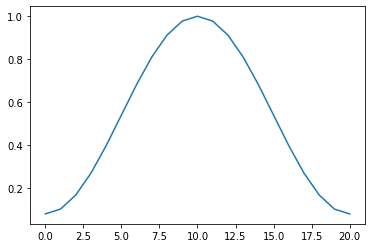

In [10]:
plt.plot(hamming)
plt.show()

In [11]:
size = (FILTER_SIZE, FILTER_SIZE)
FSpaceRows = 2 * np.fft.fftshift(np.fft.fftfreq(size[0]))
FSpaceRowsM = np.outer(FSpaceRows, np.ones([1, size[1]]))
FSpaceCols = 2 * np.fft.fftshift(np.fft.fftfreq(size[1]))
FSpaceColsM = np.outer(np.ones([1, size[0]]), FSpaceCols)

FreqR = np.sqrt(np.square(FSpaceRowsM) + np.square(FSpaceColsM))

In [12]:
FilterF = FreqR <= 0.1

/tmp/ipykernel_54575/2224310574.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figFilter.show()


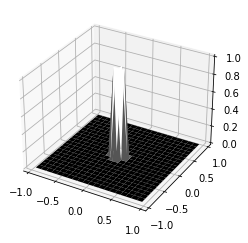

In [13]:
figFilter = plt.figure()
axsFilter = figFilter.add_subplot(projection='3d')
axsFilter.plot_surface(FSpaceRowsM, FSpaceColsM, FilterF, rstride=1, cstride=1, cmap=plt.get_cmap('gray'), linewidth=0)
figFilter.show()

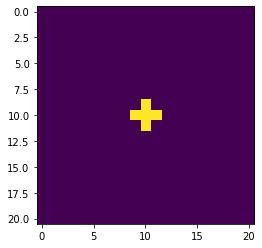

In [28]:
plt.imshow(FilterF)
plt.show()

In [35]:
FilterFRot = np.rot90(np.fft.fftshift(np.rot90(FilterF, 2)), 2)
FilterFRot3 = np.dstack((FilterFRot, np.zeros(FilterFRot.shape)))
FilterFidft = cv2.idft(np.float32(FilterFRot3),
             flags=cv2.DFT_SCALE | cv2.DFT_COMPLEX_OUTPUT)
FilterFI = np.rot90(np.fft.fftshift(FilterFidft[:, :, 0]), 2)

In [36]:
np.max(FilterFI)

0.01133787

In [37]:
np.sum(FilterFI)

1.0

(21, 21)


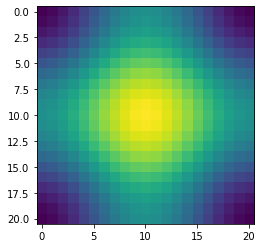

In [38]:
print(FilterFI.shape)
plt.imshow(FilterFI)
plt.show()

In [39]:
correct_filter = FilterFI * hanning2d

/tmp/ipykernel_54575/1760884799.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figFilter.show()


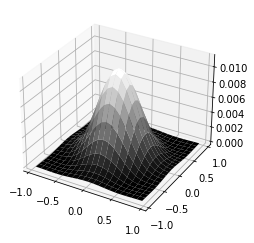

In [40]:
figFilter = plt.figure()
axsFilter = figFilter.add_subplot(projection='3d')
axsFilter.plot_surface(FSpaceRowsM, FSpaceColsM, correct_filter, rstride=1, cstride=1, cmap=plt.get_cmap('gray'), linewidth=0)
figFilter.show()

In [41]:
correct_filter.shape

(21, 21)

In [42]:
padding = (lena.shape[0] - FILTER_SIZE) // 2
lacking = (lena.shape[0] - FILTER_SIZE) % 2
pad_filter = cv2.copyMakeBorder(
    correct_filter, 
    padding + lacking,
    padding, 
    padding + lacking, 
    padding, 
    cv2.BORDER_CONSTANT, 
    value=0
)

In [43]:
ff = fourier(pad_filter)
a = np.sqrt(np.square(ff[..., 0]) + np.square(ff[..., 1]))

/tmp/ipykernel_54575/2379797415.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figFilter.show()


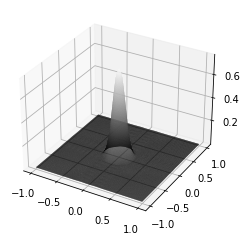

In [50]:
size = a.shape
FSpaceRows = 2 * np.fft.fftshift(np.fft.fftfreq(size[0]))
FSpaceRowsM = np.outer(FSpaceRows, np.ones([1, size[1]]))
FSpaceCols = 2 * np.fft.fftshift(np.fft.fftfreq(size[1]))
FSpaceColsM = np.outer(np.ones([1, size[0]]), FSpaceCols)

figFilter = plt.figure()
axsFilter = figFilter.add_subplot(projection='3d')
axsFilter.plot_surface(FSpaceRowsM, FSpaceColsM, a, rstride=1, cstride=1, cmap=plt.get_cmap('gray'), linewidth=0)
figFilter.show()

In [44]:
def ifourier(f):
    f = np.fft.ifftshift(f, axes=[0, 1])
    ifft = cv2.idft(f, flags=cv2.DFT_SCALE | cv2.DFT_COMPLEX_OUTPUT)
    image = cv2.magnitude(ifft[:, :, 0], ifft[:, :, 1])
    image = np.round(image).astype(np.uint8)
    return image

In [45]:
def fourier_filter(image, filter_f):
    f = fourier(image)
    FilterF3 = np.repeat(filter_f[:, :, np.newaxis], 2, axis=2)
    rev = ifourier(FilterF3 * f)
    return rev

In [46]:
rev = fourier_filter(lena, a)

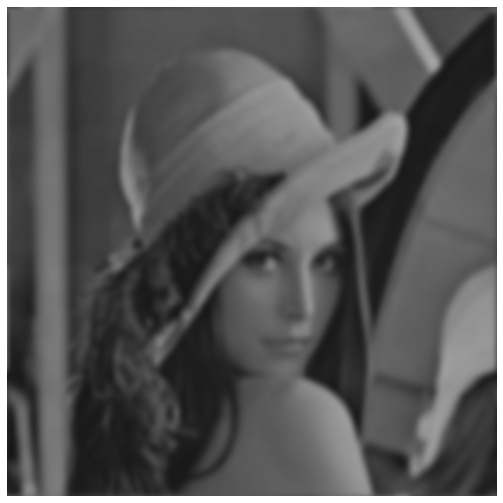

In [47]:
imshow(rev)